<div style="background:#FFFFAA">
<img src="./utils/LogoL2RPN.jpg", width=150, ALIGN="left", border=10>
<h1>L2RPN Starting Kit </h1> 


ALL INFORMATION, SOFTWARE, DOCUMENTATION, AND DATA ARE PROVIDED "AS-IS". The CDS, CHALEARN, AND/OR OTHER ORGANIZERS OR CODE AUTHORS DISCLAIM ANY EXPRESSED OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR ANY PARTICULAR PURPOSE, AND THE WARRANTY OF NON-INFRIGEMENT OF ANY THIRD PARTY'S INTELLECTUAL PROPERTY RIGHTS. IN NO EVENT SHALL AUTHORS AND ORGANIZERS BE LIABLE FOR ANY SPECIAL, 
INDIRECT OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES WHATSOEVER ARISING OUT OF OR IN CONNECTION WITH THE USE OR PERFORMANCE OF SOFTWARE, DOCUMENTS, MATERIALS, PUBLICATIONS, OR INFORMATION MADE AVAILABLE FOR THE CHALLENGE. 
</div>

<div style="background:#FFFFAA">
    <h2>Introduction </h2>
    <p> 
     <br>
The goal of this challenge is to use Reinforcement Learning in Power Grid management by designing RL agents to automate the control of the power grid. We are using a power network simulator : <a href="https://github.com/MarvinLer/pypownet">pypownet</a>, it is a simulator that is able to emulate a power grid of any size and electrical properties subject to a set of temporal injections for discretized time-steps.

References and credits: <br>
Creator of pypownet was Marvin Lerousseau, using Matpower and OpenGym tools. The competition was designed by Isabelle Guyon, Antoine Marot, Benjamin Donnot and Balthazar Donon. Luca Veyrin, Camillo Romero and Kimang Khun are distinguished contributors to make the L2RPN challenge happen. 
 <br> 
</div>

Useful paths for the submission and for data

In [1]:
model_dir = 'example_submission/'
problem_dir = 'utils/ingestion_program/'  
score_dir = 'utils/scoring_program/'
ref_data = 'utils/public_ref/'
ingestion_output = 'utils/logs/'

input_dir = 'public_data/'
output_dir = 'utils/output/'

In [22]:
from sys import path;
path.append(model_dir); path.append(problem_dir); path.append(score_dir);
path.append(input_dir); path.append(output_dir);
path.append('.')

Using TensorFlow backend.


Useful external libraries for this notebook

In [3]:

import sys
import logging
import os
#%matplotlib inline
# Uncomment the next lines to auto-reload libraries (this causes some problem with pickles in Python 3)
%load_ext autoreload
%autoreload 2
#import seaborn as sns; sns.set()
import warnings
import numpy as np
import pandas as pd
import evaluate
%matplotlib inline
import matplotlib.pyplot as plt
import json

warnings.simplefilter(action='ignore', category=FutureWarning)

<div style="background:#FFFFAA">
    <h1> Step 1: Exploratory data analysis </h1>
</div>

## Electrical grid
<div >
<img src="utils/IEEE14Example.png", width=750, ALIGN="left", border=20>
    <br>
    <br>
(courtesy of Marvin Lerousseau)
</div>

During the challenge, a grid of 14 substations is given. 20 lines are connected through the nodes of the grids within substations.

explore others notebooks for better understanding of the power network behavior: 
 - Power_Grid_101_notebook.ipynb
 - visualize_14grid_with_customized_actions.ipynb

In our grid environment, we take the case where there are 11 loads and 5 prods. Furthermore, we will only consider chronics over the month of January, the only month for which contestants are tested.

In [4]:


loads_p_file = '_N_loads_p.csv' #active power chronics for loads
prods_p_file = '_N_prods_p.csv'  #active power chronics for productions
datetimes_file = '_N_datetimes.csv' #timesstamps of the chronics
maintenance_file = 'maintenance.csv' #maintenance operation chronics. No maintenance considered in the first challenge
hazards_file = 'hazards.csv'   #harzard chronics that disconnect lines. No hazards considered in the first challenge
imaps_file = '_N_imaps.csv' #thermal limits of the lines

i = 0 # chronics id
data_dir = input_dir+"datasets" #repository where to find all the chronics for a given difficulty level
path = data_dir+'/chronics/0000/'


We now load all data chronics to later visualize them. They will however be automaticall loaded in pypownet environment when run.

In [5]:
df_loads_p = {}
df_prods_p = {}
df_datetimes = {}
df_maintenance = {}
df_hazards = {} 

df_loads_p[str(i)] = pd.read_csv(path+loads_p_file, sep=';')
df_prods_p[str(i)] = pd.read_csv(path+prods_p_file, sep=';')
df_datetimes[str(i)] = pd.read_csv(path+datetimes_file, sep=';')
df_loads_p[str(i)].index = pd.to_datetime(df_datetimes[str(i)]['date'] + ' ' + df_datetimes[str(i)]['time'])
df_prods_p[str(i)].index = pd.to_datetime(df_datetimes[str(i)]['date'] + ' ' + df_datetimes[str(i)]['time'])
df_maintenance[str(i)] = pd.read_csv(path+maintenance_file, sep=';')
df_maintenance[str(i)].index = pd.to_datetime(df_datetimes[str(i)]['date'] + ' ' + df_datetimes[str(i)]['time'])
df_hazards[str(i)] = pd.read_csv(path+hazards_file, sep=';')
df_hazards[str(i)].index = pd.to_datetime(df_datetimes[str(i)]['date'] + ' ' + df_datetimes[str(i)]['time'])
df_imaps = pd.read_csv(path + imaps_file, sep=';')


## Loads

The following figure shows the active power of consumptions which represents the amount of demand of active power. You can notice the daily seasonality as well as the weekdays and weekend difference in consuming behavior. In our particular case, the load 3_C151.15 at substation 3 is the one which has the highest demand. The loads for the other levels are pretty similar with a load needing much more power than the others.

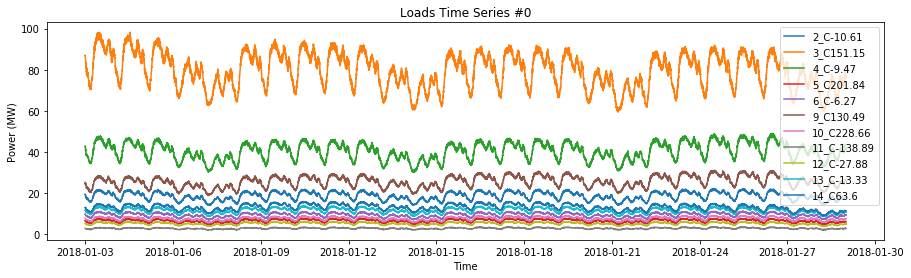

In [6]:
plt.figure(figsize=[15,4])
plt.title('Loads Time Series #'+str(0))
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.plot(df_loads_p[str(0)])
plt.legend(list(df_loads_p[str(0)]))
plt.show()

## Production

The active power of the productions is shown below. We have a quite stable nuclear production as well as renewable energies, wind and solar, with a high variance. FInally a thermal power plant matches the residual demand.

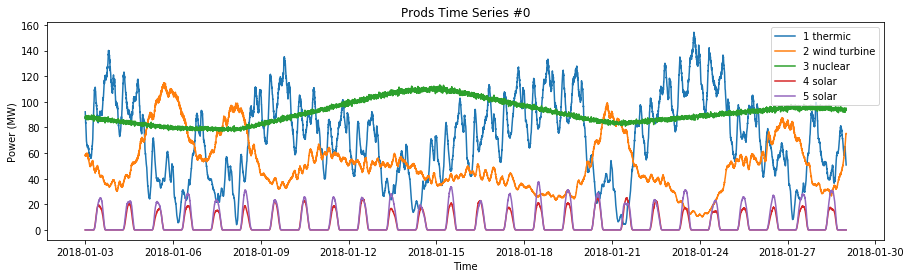

In [7]:
plt.figure(figsize=[15,4])
plt.title('Prods Time Series #'+str(0))
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.plot(df_prods_p[str(0)])
#plt.legend(list(df_prods_p[str(0)]))
plt.legend(["1 thermic", "2 wind turbine", "3 nuclear", "4 solar", "5 solar"])
plt.show()

## Maintenance & Hazards

Pypownet handle mintenance and hazards in the scenarios. But in this competition there is no hazard and maintenance operations. However overloads can still occur and have to be managed.

<div style="background:#FFFFAA">
<h1>Step 2: Building an Agent</h1>
</div>

<div style="background:#FFFFAA">
    <h2>Building an agent</h2>
    <p>
We provide simple examples of agent in the `starting-kit/example_submission` directory. We illustrate it here with the most simple agent: the lazy "do nothing". To make your own agent, you can change the agent init to load your own model, you can modify the act method to take action with your model and specify a reward, especially if you are doing reinforcement learning.
    </div>

## Do nothing agent

The agent does not take any actions.

In [8]:
import pypownet.agent
import pypownet.environment

class DoNothingAgent(pypownet.agent.Agent):
    """ The template to be used to create an agent: any controller of the power grid is expected to be a daughter of this
    class.
    """

    def __init__(self, environment):
        """Initialize a new agent."""
        assert isinstance(environment, pypownet.environment.RunEnv)
        self.environment = environment

    def act(self, observation):
        return self.environment.action_space.get_do_nothing_action()

    def feed_reward(self, action, consequent_observation, rewards_aslist):
        pass

To make a submission on the challenge, you should name your agent Submission and write in submission.py file.

Here is an example with the doNothing agent: we changed the name of the agent as Submission and can write it in a .py file by uncommenting the %%writefile

In [9]:
#%%writefile example_submission/submission.py
import pypownet.agent
import pypownet.environment

class Submission(pypownet.agent.Agent):
    """ The template to be used to create an agent: any controller of the power grid is expected to be a daughter of this
    class.
    """

    def __init__(self, environment):
        """Initialize a new agent."""
        assert isinstance(environment, pypownet.environment.RunEnv)
        self.environment = environment

    def act(self, observation):
        return self.environment.action_space.get_do_nothing_action()

    def feed_reward(self, action, consequent_observation, rewards_aslist):
        pass
#if you want to load a file (in this directory) names "model.dupm"
#open("program/model.dump")

## Other baselines

Uncomment one of the lines below to see the code of the agent : (keep the ??)

In [10]:
import baseline_agents

#??baseline_agents.DoNothing
#??baseline_agents.RandomLineSwitch
#??baseline_agents.RandomNodeSplitting


## The Reward and the Score of an agent
At each step pypownet return a reward to the agent.

This reward is used to compute the Score for ranking participants in this current challenge.
the final Score is the sum of the score of each scenario. for a scenario there is two option :
 - Your agent got a game over, the Score for this scenario is 0
 - your agent got no game over, the Score of this scenario is the sum of the reward at each timestep of this scenario
 
### Computation of the reward
For each timestep pypownet returns a reward : the sum of the squared flow for each line <br>
<p>
    \[
        R= \sum_{l\in lines} \max\left(1- \frac{i_l}{i_{l_{max}}}^2,0\right)
    \]
</p>
With $i_l$ the flow on the line l and $i_{l_{max}}$ the maximum allowed flow on this line.<br>
The final score on one chronic is the sum of the rewards over the each timestep

for better understanding of the reward calulation please look at <code>public_data/reward_function.py</code> for training purposes you can modify this function. 


### Run an agent 

Once you have defined an agent, you can run it under an environment over scenarios.

NB: The runner from pypownet is perfectly fine but for the need of the leaderboard and its visualizations, the runner was augmented. The "augmented" version can be found in the starting kit. This is the runner that will run on the Codalab competition server. So before making a submission, make sure it runs with this runner as well. In the following you can choose one or the other, but to obtain a score as on the leaderboard, you need to run the "augmented" runner.

In [11]:

#from pypownet.runner import Runner
from runner import Runner #an override of pypownet.runner 
import os
import pypownet.environment

data_dir = 'public_data'  

def set_environement(game_level = "datasets", start_id=0):
    """
        Load the first chronic (scenario) in the directory public_data/datasets 
    """
    return pypownet.environment.RunEnv(parameters_folder=os.path.abspath(input_dir),
                                              game_level=game_level,
                                              chronic_looping_mode='natural', start_id=start_id,
                                              game_over_mode="soft")

def run_agent(environment, agent, number_iterations):
    # Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
    # by the scoring program
    log_path = os.path.abspath(os.path.join(ingestion_output, 'runner.log'))
    machinelog_filepath = os.path.abspath(os.path.join(ingestion_output,'machine_log.json'))# set to None 
    phase_runner = Runner(environment, submitted_controler, verbose=True, vverbose=False,
                                          log_filepath=log_path, machinelog_filepath=machinelog_filepath)
    phase_runner.ch.setLevel(logging.ERROR)
    # Run the planned experiment of this phase with the submitted model
    score = phase_runner.loop(iterations=number_iterations)
    print("cumulative reward : {}".format(score))
    return score




Now run it. 

You could load the agent from your own submission in submission.py. We explain after how to make a submission

In [35]:
import submission #existing exemple as submission.py

NUMBER_ITERATIONS = 100 # The number of iterations can be changed

sys.path.append(model_dir)

if not os.path.exists(ingestion_output):
    os.makedirs(ingestion_output)
log_path = os.path.abspath(os.path.join(ingestion_output, 'runner.log'))
open(log_path, 'w').close()


# Uncoment one of the lines below
#agent = baseline_agents.DoNothing
#agent = baseline_agents.RandomLineSwitch
#agent = baseline_agents.RandomNodeSplitting

#or you can try your own submission
Agent = submission.Submission
#agent = DoNothingAgent
env = set_environement()

submitted_controler = Agent(env)
_ = run_agent(env, submitted_controler, NUMBER_ITERATIONS)


Storing actions at saved_actions/AgentPolicyGradient.csv
cumulative reward : 503.4894796437077


**WARNING**: the following cell to compute the leaderboard score will not run if you did not use the "augmented" runner previously.

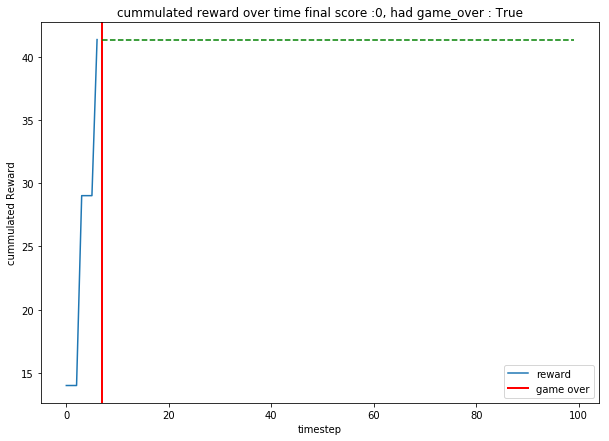

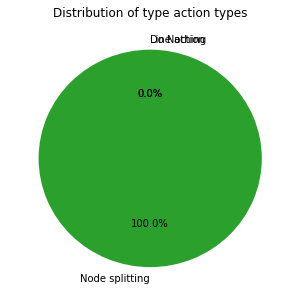

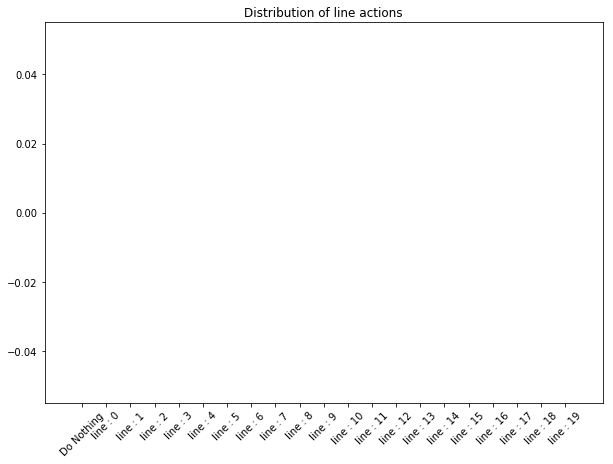

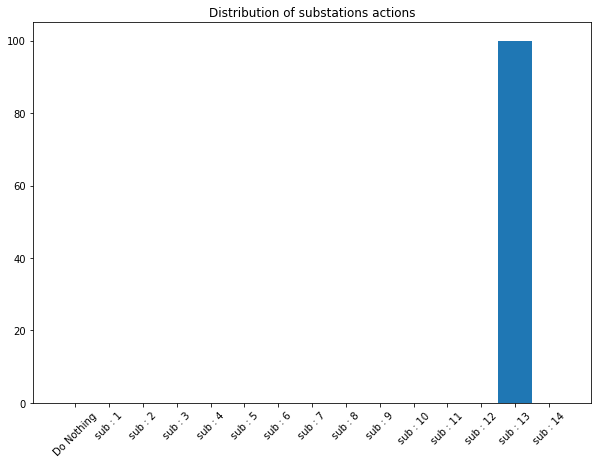

In [34]:
import evaluate
scoring_function = evaluate.extract_json
action_space = evaluate.get_action_space(os.path.join('utils',"ref"))
_ = scoring_function(os.path.join(ingestion_output, "machine_log.json"),action_space)

<div style="background:#FFFFAA">
    <b> Save the best agent </b> it should be a class Submission and save in "example_submission/submission.py".  Uncomment the line <i>%%writefile example_submission/submission.py to save the agent. </i>
</div>

<div style="background:#FFFFAA">
<h1> Step 3: Making a submission </h1> 

<h2> Unit testing </h2> 

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is create or modify the <code>Sumbission</code> class the file <code>submission.py</code>  in the <code>starting_kit/example_submission/</code> directory, then run this test to make sure everything works fine. This is the actual program that will be run on the server to test your submission. <br>

take note that on codalab, your local directory is <code>program/</code>. Then if you want to load the file <code>model.dump</code> run : <code>open("program/model.dum")</code> even if the file is in at the root of your submission dir.
</div>

In [14]:
#codalab command line used on the competition server. So it is best to test it as it is, rather than directly importing the related python method here and execute it. 
#you are supposed to run python 3 here. If "!python" command does not work, try "!python3" 
!python $problem_dir/ingestion.py $input_dir utils/res $problem_dir $model_dir

input dir: /Users/lunghino/enelx_l2rpn/public_data
output dir: /Users/lunghino/enelx_l2rpn/utils/res
program dir: /Users/lunghino/enelx_l2rpn/utils/ingestion_program
submission dir: /Users/lunghino/enelx_l2rpn/example_submission
input content ['full_chronic_names.json', 'reward_signal.py', 'datasets', '4_substations', '__pycache__', 'chronic_names.json']
output content ['log_files.json', 'runner.log', 'machine_log_1.json', 'machine_log_0.json', 'machine_log_3.json', 'machine_log_2.json']
program content ['ingestion.py', 'runner.py', '__pycache__', 'metadata']
submission content ['baseline_agents.py', 'submission.py', 'policy_grad_weights.h5', '__pycache__', 'metadata', 'example_submission.zip']
Using custom reward signal CustomRewardSignal of file /Users/lunghino/enelx_l2rpn/public_data/reward_signal.py
log file path /Users/lunghino/enelx_l2rpn/utils/res/runner.log
log file path /Users/lunghino/enelx_l2rpn/utils/res/runner.log
log file path /Users/lunghino/enelx_l2rpn/utils/res/runner.

<div style="background:#FFFFAA">
Also test the scoring program:
    </div>

In [15]:
scoring_output_dir = 'results'

#you are supposed to run python3 here. If "!python" command does not work, try "!python3" 
!python $score_dir/evaluate.py utils $scoring_output_dir
print("watch : http:/view/"+ scoring_output_dir +"/scores.html")

utils
results
Using custom reward signal CustomRewardSignal of file /Users/lunghino/enelx_l2rpn/utils/ref/reward_signal.py
watch : http:/view/results/scores.html


<div style="background:#FFFFAA">
    <h1> Preparing the submission </h1>

Zip the contents of `sample_code_submission/` (without the directory), or download the challenge public_data and run the command in the previous cell, after replacing sample_data by public_data.
Then zip the contents of `sample_result_submission/` (without the directory).
<b><span style="color:red">Do NOT zip the data with your submissions</span></b>.

In [16]:
import datetime 
import zipfile

def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))

the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
sample_code_submission = 'sample_code_submission_' + the_date + '.zip' 

with zipfile.ZipFile(sample_code_submission, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipdir(model_dir,zipf)
print("Submit one of these files:\n" + sample_code_submission + "\n")

Submit one of these files:
sample_code_submission_19-05-26-20-39.zip

